# Comparing different strategies for Reinforcement Learning for Poker



## 1. Libraries and setup 

Install this if needed before running the code.

Depending on which configuration you are, you only need :
pip install ...

Below it was for my Mac M1 on Visual Studio Code

python3 -m pip install pypokerengine    
python3 -m pip install matplotlib     
python3 -m pip install torch    
python3 -m pip install rlcard tensorflow

python3 -m pip install scikit-learn

The project use a poker environement from a library found on github called RL Card

https://github.com/datamllab/rlcard/tree/master

In [69]:
#import argparse
import pprint

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import set_seed
import numpy as np

# Make environment
env = rlcard.make(
    'no-limit-holdem',
    config={
        'seed': 42,
    }
)

# Seed numpy, torch, random
set_seed(42)

# Set agents
agent = RandomAgent(num_actions=env.num_actions)
env.set_agents([agent for _ in range(env.num_players)])

# Generate data from the environment
trajectories, player_wins = env.run(is_training=False)
# Print out the trajectories
print("we print this just to see what the data looks like, and to see what we can acccess from it.")
print('\nTrajectories:')
print(trajectories)
print('\nSample raw observation:')
pprint.pprint(trajectories[0][0]['raw_obs'])
print('\nSample raw legal_actions:')
pprint.pprint(trajectories[0][0]['raw_legal_actions'])
print('\nSample raw legal_stakes:')
#pprint.pprint(trajectories[0][0]['stakes'])



we print this just to see what the data looks like, and to see what we can acccess from it.

Trajectories:
[[{'legal_actions': OrderedDict([(0, None), (1, None), (3, None), (4, None)]), 'obs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2.]), 'raw_obs': {'hand': ['HK', 'D4'], 'public_cards': [], 'all_chips': [1, 2], 'my_chips': 1, 'legal_actions': [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>], 'stakes': [99, 98], 'current_player': 0, 'pot': 3, 'stage': <Stage.PREFLOP: 0>}, 'raw_legal_actions': [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>], 'action_record': [(0, <Action.RAISE_POT: 3>), (1, <Action.RAISE_POT: 3>), (0, <Action.ALL_IN: 4>), (1, <Action.FOLD: 0>)]}, 3, {'legal_actions': OrderedDict([(0, None), (1, None)

## 2. Creation of Agent Classes
### 2.1 Always Call Agent
Now we create an agent that consistently calls the opponent's actions. The gaol is to establish a baseline for a player employing a straightforward strategy.

In [70]:
class Always_Call_Agent(object):
    def __init__(self, num_actions):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.use_raw = False
        self.num_actions = num_actions

    @staticmethod
    def step(state):
        ''' Predict the action given the curent state in gerenerating training data.
        Args:
            state (dict): An dictionary that represents the current state
        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
        '''
        return 1 # Always call, different actions goes from 0 to 4 


    def eval_step(self, state):
        ''' Predict the action given the current state for evaluation.
        '''
        probs = [0 for _ in range(self.num_actions)]
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]] for i in range(len(state['legal_actions']))}

        return self.step(state), info
    
    def feed(self, ts):
        return None


### 2.2 Special Agent

Now we create a function to detect if we have a certain type of hand (useful for later).
And a agent that play some kind of optimal strategy to see if the reinforcement learning algorithm can be better or at least equal

In [71]:
#this function checks if the hand is suited connectors (two cards of the same suit and consecutive values)
def is_suited_connector(hand):
    suits = [card[0] for card in hand]
    value_ranks = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, 'T': 8, 'J': 9, 'Q': 10, 'K': 11, 'A': 12}
    values = sorted([card[1:] for card in hand], key=lambda x: value_ranks[x[0] if len(x) == 2 else x])
    
    if len(set(suits)) == 1:  # Check if all cards are of the same suit
        for i in range(len(values) - 1):
            if value_ranks[values[i][0] if len(values[i]) == 2 else values[i]] + 1 == value_ranks[values[i+1][0] if len(values[i+1]) == 2 else values[i+1]]:
                return True  # Found suited connectors
    return False 

#this agent is a special agent that plays poker based on some rules that are defined in the step function
class SpecialAgent(object):
    ''' A random agent. Random agents is for running toy examples on the card games
    '''

    def __init__(self, num_actions):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.use_raw = False
        self.num_actions = num_actions

    @staticmethod
    def step(state):
       
        myhand = state['raw_obs']['hand']
        #stakes = state['raw_obs']['stakes']
        values = [card[1:] for card in myhand]
        value_counts = {value: values.count(value) for value in values}
        possible_actions = list(state['legal_actions'].keys())  # 0: fold, 1: call, 2: raise half pot, 4: all in
        #pot = state['raw_obs']['pot']
        #public_cards = state['raw_obs']['public_cards']   # if public_cards is empty, it is preflop
        stage = state['raw_obs']['stage'].name   # The current stage of the game preflop flop, turn or river

        undesired_combinations = ['27','28', '29', '2T', '2J', '37', '38', '39', '3T', '3J', '48', '49', '4T', '4J', '58', '59', '5T', '5J']
        desired_combinations = [
    "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "AA", "AJ", "AK", "AQ", "AT",
    "J2", "J3", "J4", "J5", "J6", "J7", "J8", "J9", "JJ",
    "K6", "K7", "K8", "K9", "KJ", "KK", "KT", "KQ",
    "Q8", "Q9", "QJ", "QQ", "QT",
    "T8", "T9", "TT",
    "55","66", "77", "88", "98", "99"
]
        

        # Check if the stage is PREFLOP and if myhand meets the undesired combinations criteria, if yes we fold
        if stage == "PREFLOP" and any(myhand[0][1] + myhand[1][1] == combo for combo in undesired_combinations):
            #print(myhand)
            return 0
        # if we have a good combination we raise
        elif stage =="PREFLOP" and (
                any(count >= 2 for count in value_counts.values()) 
                or is_suited_connector(myhand) 
                or any(myhand[0][1] + myhand[1][1] == combo for combo in desired_combinations)
                or any(myhand[0][1] == card[1] for card in myhand)) and 3 in possible_actions:
            
            #print("raise pot preflop", myhand[0][1], myhand[1][1])
            return 3
        
            # otherwise we call
        elif stage =="PREFLOP":
            #print("call preflop ", myhand)
            return 1
        
        # flop
        elif stage =="FLOP" :
            if 2 in possible_actions and (any(count >= 2 for count in value_counts.values()) 
                or any(myhand[0][1] + myhand[1][1] == combo for combo in desired_combinations)
                or is_suited_connector(myhand) ):
                #print("raise half pot flop", myhand[0][1], myhand[1][1])
                #print(public_cards)
                return 2
            else:
                return 1    
        # turn
        elif stage =="TURN" :  
            return 1
        # river
        elif stage =="RIVER" :  
            if 3 in possible_actions and (any(count >= 2 for count in value_counts.values()) 
                or any(myhand[0][1] + myhand[1][1] == combo for combo in desired_combinations)
                or is_suited_connector(myhand) ):
                #print("raise half pot river", myhand[0][1], myhand[1][1])
                #print(public_cards)
                return 3
            else:
                return 1 

        else:
            return 0


    def eval_step(self, state):
        ''' Predict the action given the current state for evaluation.
            Since the random agents are not trained. This function is equivalent to step function

        Args:
            state (dict): An dictionary that represents the current state

        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
            probs (list): The list of action probabilities
        '''
        probs = [0 for _ in range(self.num_actions)]
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]] for i in range(len(state['legal_actions']))}

        return self.step(state), info
    
    def feed(self, ts):
        return None


## 3. Agent with reinforcement learning 

### 3.1 Training of the Agent
Everytime the agent that will play against players that play randomly

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  2.035
----------------------------------------
INFO - Step 100, rl-loss: 389.4891052246094
INFO - Copied model parameters to target network.
INFO - Step 169, rl-loss: 1262.0145263671875
----------------------------------------
  episode      |  100
  reward       |  3.5645
----------------------------------------
INFO - Step 332, rl-loss: 316.91400146484375
----------------------------------------
  episode      |  200
  reward       |  1.901
----------------------------------------
INFO - Step 507, rl-loss: 1893.7307128906255
----------------------------------------
  episode      |  300
  reward       |  1.6405
----------------------------------------
INFO - Step 657, rl-loss: 1552.3599853515625
----------------------------------------
  episode      |  400
  reward       |  2.9295
----------------------------------------
INFO - Step 832, rl-loss: 958.70324707031255
----------------

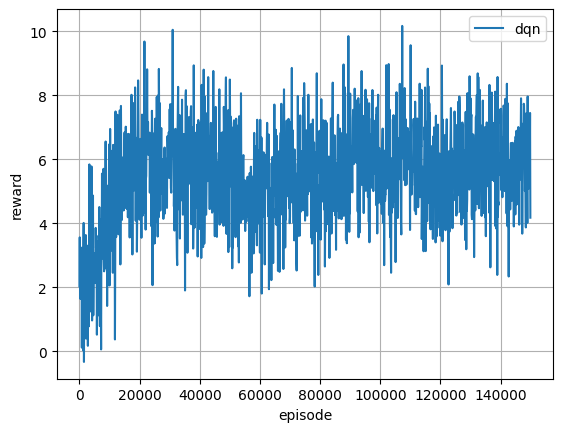

In [72]:
import os
import torch

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'dqn'           #change the algorithm by dqn, Always_Call, Special, Always_Raise, nfsp
log_dir = './logs/'
num_episodes = 150000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[64,64],
        q_mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
traj_per_episode = []  # we store the trajectory of each episode

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        traj = []
        for ts in trajectories[0]:
            event = {}
            event["me"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            event["opponent"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            traj.append(event)
        traj_per_episode.append(traj) 
        for ts in trajectories[0]:
            #if (ts[0]['raw_obs']['stage'].name == "PREFLOP"):
            #    folded_hands_played.append(ts[3]['action_record'][-1][1].name)
            #    raise_hands_played.append(ts[3]['action_record'][-1][1].name)
            #elif (len(ts[0]['raw_obs']['public_cards']) == 0 and ts[3]['action_record'][-1][1].name != "FOLD" and ts[3]['raw_obs']['stage'].name == "RIVER"):
                #print(ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name)
                #print(ts[0]['raw_obs']['hand'])
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))
                #hand_played.append((ts[0]['raw_obs']['hand'], ts[0]['raw_obs']['legal_actions']))


    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



### 3.1 Regression of DQN Agent
We calculate the regression with the optimal coefficients and add the regression line to visualize the trend more clearly.

It is important to note that poker has significant variance; sometimes, a hand that has an 80% chance of winning can still lose even 10 times in a row. Therefore, we ran a large number of episodes to better observe the overall trend.

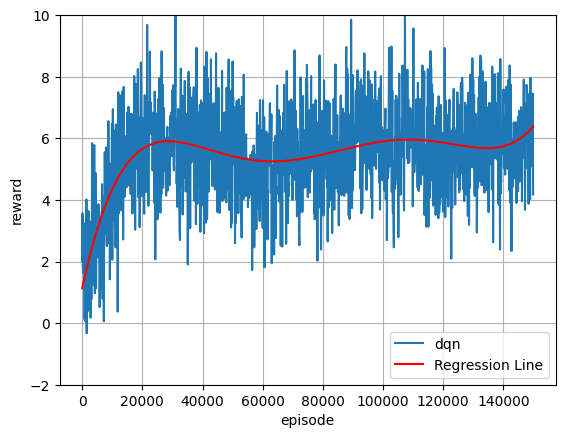

The optimal degree of the regression curve is : 5
Once it reaches 20,000 episodes, the performance plateaus, and on average, a DQN agent achieves a reward of 5.675688121787632


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]
# Split data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Try different polynomial degrees
degrees = range(1, 6)  # Try degrees from 1 to 5
best_degree = None
best_mse = float('inf')

for degree in degrees:
    # Fit polynomial regression
    coefficients = np.polyfit(x_train, y_train, degree)
    polynomial = np.poly1d(coefficients)

    # Evaluate on validation set
    y_pred = polynomial(x_val)
    mse = mean_squared_error(y_val, y_pred)
    
    # Update best degree if this degree performs better
    if mse < best_mse:
        best_mse = mse
        best_degree = degree

# Use the best degree to fit the final model
coefficients = np.polyfit(x, y, best_degree)
polynomial = np.poly1d(coefficients)

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)

# Calculate regression line

coefficients = np.polyfit(x, y, best_degree)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression line
plt.plot(x, y_reg, color='r', label='Regression Line')
plt.ylim(-2, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()
print("The optimal degree of the regression curve is :", best_degree)
c= len(y_reg)-150
print("Once it reaches 20,000 episodes, the performance plateaus, and on average, a DQN agent achieves a reward of", sum(y_reg[-c:])/len(y_reg[-c:]))


We will later compare this reward with those of other models to evaluate its effectiveness.

Before continuing, a few points to note:
- We attempted to tweak the parameters of the DQN agent, but it did not significantly increase the reward.
- Increasing the number of episodes did not change the fact that the DQN algorithm plateaus after 15,000 episodes (even with 300,000 episodes).

### 3.2 Statistics about the DQN model 
What did the model do during training? Did it learn well or not?

#### 3.2.1 Ratios of actions  


During the all the training, the model has a:
Ratio of call hands played: 0.31078
Ratio of fold hands played: 0.056753333333333336
Ratio of raise pot hands played: 0.45014
Ratio of raise half pot hands played: 0.0
Ratio of all in hands played: 0.18232666666666666


During the beggining of the training for the first 1000 hands, the model has a:
Ratio of call hands played: 0.2488
Ratio of fold hands played: 0.2157
Ratio of raise half pot hands played: 0.0
Ratio of raise hands played: 0.2211
Ratio of all in hands played: 0.3144


During the end of the training for the last 1000 hands, the model has a:
Ratio of call hands played: 0.4608
Ratio of fold hands played: 0.0382
Ratio of raise half pot hands played: 0.0
Ratio of raise hands played: 0.4017
Ratio of all in hands played: 0.0993




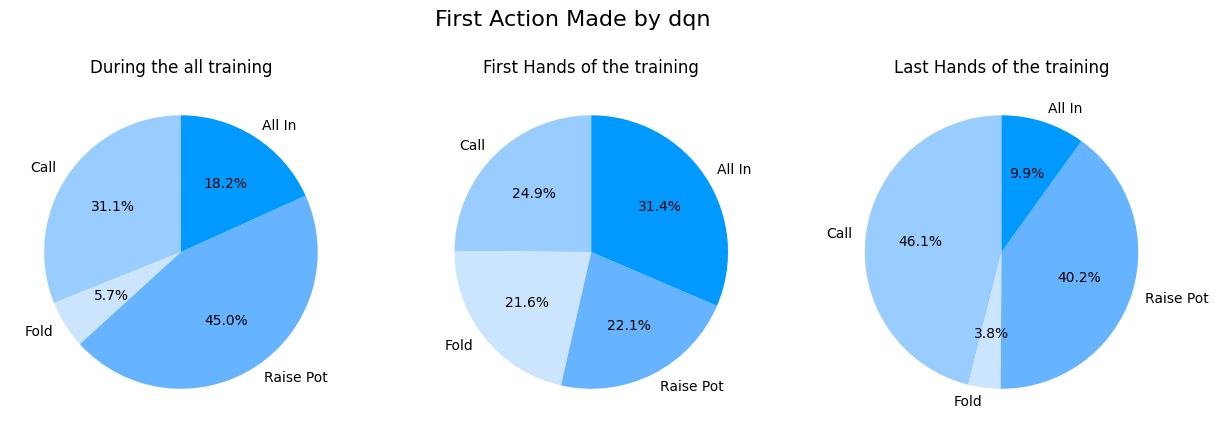

In [75]:
hands_only = [ep[0]["me"]["hand"] for ep in traj_per_episode] # Extract the hands played
action_made = [ep[0]["me"]["action"] for ep in traj_per_episode] # Extract the actions made FOLD, CHECK_CALL, ...
#stage_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
#stakes_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode]   # Extract the stakes played

print("During the all the training, the model has a:")
# Calculate the ratio of calling hands played
raise_ratio_call = action_made.count(1) / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count(0) / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made.count(3) / len(action_made)
print("Ratio of raise pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made.count(2) / len(action_made)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count(4) / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")
number = int((num_episodes)/15)  # we take the first 10% hands and the last 10% hands
hands_only_1000 = hands_only[:number] 
action_made_1000 = action_made[:number]
#stage_played_1000 = stage_played[:number]
#stakes_played_1000 = stakes_played[:number] 

print("During the beggining of the training for the first 1000 hands, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made_1000.count(1) / len(action_made_1000)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made_1000.count(0) / len(action_made_1000)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made_1000.count(2) / len(action_made_1000)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made_1000.count(3) / len(action_made_1000)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made_1000.count(4) / len(action_made_1000)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")


hands_only_1000_end = hands_only[-number:]
action_made_1000_end = action_made[-number:]
##stage_played_1000_end = stage_played[-number:]
#stakes_played_1000_end = stakes_played[-number:]

print("During the end of the training for the last 1000 hands, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made_1000_end.count(1) / len(action_made_1000_end)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made_1000_end.count(0) / len(action_made_1000_end)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made_1000_end.count(2) / len(action_made_1000_end)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made_1000_end.count(3) / len(action_made_1000_end)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made_1000_end.count(4) / len(action_made_1000_end)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")


from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import os
# Calculate the ratios of different actions made overall
total_actions = len(action_made)
raise_ratio_call = action_made.count(1) / total_actions
raise_ratio_fold = action_made.count(0) / total_actions
raise_ratio_half_pot = action_made.count(2) / total_actions
raise_ratio_pot = action_made.count(3) / total_actions
raise_ratio_allin = action_made.count(4) / total_actions

# Calculate the ratios of different actions made in the first 1000 hands
total_actions_1000 = len(action_made_1000)
raise_ratio_call_1000 = action_made_1000.count(1) / total_actions_1000
raise_ratio_fold_1000 = action_made_1000.count(0) / total_actions_1000
raise_ratio_half_pot_1000 = action_made_1000.count(2) / total_actions_1000
raise_ratio_pot_1000 = action_made_1000.count(3) / total_actions_1000
raise_ratio_allin_1000 = action_made_1000.count(4) / total_actions_1000

# Calculate the ratios of different actions made in the last 1000 hands
total_actions_1000_end = len(action_made_1000_end)
raise_ratio_call_1000_end = action_made_1000_end.count(1) / total_actions_1000_end
raise_ratio_fold_1000_end = action_made_1000_end.count(0) / total_actions_1000_end
raise_ratio_half_pot_1000_end = action_made_1000_end.count(2) / total_actions_1000_end
raise_ratio_pot_1000_end = action_made_1000_end.count(3) / total_actions_1000_end
raise_ratio_allin_1000_end = action_made_1000_end.count(4) / total_actions_1000_end

# Pie chart data
labels = ['Call', 'Fold', 'Raise Pot', 'All In']
colors = ['#99CCFF', '#CCE5FF', '#66B3FF','#0099FF']

sizes = [raise_ratio_call, raise_ratio_fold, raise_ratio_pot, raise_ratio_allin]
sizes_1000 = [raise_ratio_call_1000, raise_ratio_fold_1000, raise_ratio_pot_1000, raise_ratio_allin_1000]
sizes_1000_end = [raise_ratio_call_1000_end, raise_ratio_fold_1000_end, raise_ratio_pot_1000_end, raise_ratio_allin_1000_end]
# , 'Raise Half Pot' , raise_ratio_half_pot, raise_ratio_half_pot_1000, raise_ratio_half_pot_1000_end

# Plot pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'First Action Made by {algorithm}', fontsize=16)


axs[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title('During the all training')

axs[1].pie(sizes_1000, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].set_title('First Hands of the training')

axs[2].pie(sizes_1000_end, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[2].set_title('Last Hands of the training')

plt.show()




The most interesting observation from the training process is the change in the agent's decision-making behavior. Initially, the algorithm chooses between calling, folding, raising, and going all-in approximately 25% of the time for each action. However, by the end of the training, its behavior shifts significantly:

- **Folding**: The agent folds only 3-4% of the time.
- **Raising**: The agent raises 40% of the time.
- **Checking/Calling**: The agent checks or calls 35% of the time.
- **All In**: The agent goes all in 10% of the time.

#### Notes:

- These statistics reflect only the first decision of each game during the preflop phase. Therefore, raising half pot is not included because it is not a legal action at this stage of the game.
- "First hands" refer to the first 10% of the hands played during training, which shows that the algorithm starts to learn from this initial subset, hence the percentages are not exactly 25%.
- "Last hands" refer to the last 10% of the hands played during training, highlighting the evolved strategy of the agent.

These changes indicate that the DQN agent adapts its strategy over time, moving away from random action selection towards more strategic decision-making.



#### 3.2.2 Ratios of hands
  
Check which hands was played during each training

In [76]:


def normalize_hand(hand):
    return ''.join(sorted(hand))

def plot_single_hand(hand, save_path):
    plt.figure()
    plt.bar(hand['player'], hand['player'].values(), color='blue')
    plt.xlabel('Player')
    plt.ylabel('Number of chips')
    plt.title('Last Hand')
    plt.savefig(save_path)
    plt.close()

# Flatten the list of lists and normalize each hand
all_hands = []
all_hands_with_action = []

for i in range(len(hands_only)):
    hand_value = normalize_hand(hands_only[i][0][1] + hands_only[i][1][1])
    all_hands.append(hand_value)
    all_hands_with_action.append((hand_value, action_made[i]))

# Count the frequency of each hand
hand_counts = Counter(all_hands)

# Sort the hand counts by hand value
sorted_hand_counts = sorted(hand_counts.items(), key=lambda x: x[0])

# Extract sorted keys and values
sorted_hands, sorted_frequencies = zip(*sorted_hand_counts)

# Create bar plot data
data = go.Bar(
    x=list(sorted_hands),
    y=list(sorted_frequencies),
    marker=dict(color='rgb(65, 131, 215)')
)


# Layout settings
layout = go.Layout(
    title='Frequency of Each Hand Played ',
    xaxis=dict(title='Hand'),
    yaxis=dict(title='Frequency'), 
    margin=dict(b=100),
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)


Frequency plot saved in ./logs/dqn_hand_frequency.html


This graph is mostly to see the distribution of the hands with no special purpose.

In [77]:
import os
from collections import Counter
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import plot

# Define a function to create a plot for a given subset of data
def create_frequency_plot(hand_counts_with_action, title_suffix, plot_path):
    # Sort the hand counts by hand value
    sorted_hand_counts_action = sorted(hand_counts_with_action.items(), key=lambda x: x[0])
    # Extract sorted keys and values
    sorted_hand_counts_action, sorted_frequencies = zip(*sorted_hand_counts_action)
    first_elements = [item[0] for item in sorted_hand_counts_action]
    second_elements = [item[1] for item in sorted_hand_counts_action]

    # Define shades of red
    color_palette = [
        'rgb(255, 204, 204)',  # Light red
        'rgb(255, 153, 153)',  # Medium light red
        'rgb(255, 255, 255)',  # White
        'rgb(255, 102, 102)',  # Medium dark red
        'rgb(255, 51, 51)'     # Dark red
    ]
    
    # Define action labels
    action_labels = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-in']

    # Create a list to hold colors for each bar based on adjusted_second_elements
    colors = [color_palette[val] for val in second_elements]
    
    # Create bar plot data
    data = go.Bar(
        x=list(first_elements),
        y=list(sorted_frequencies),
        marker=dict(color=colors)
    )

    # Annotations for legend
    annotations = [
        dict(
            x=1.07,
            y= 0.1 * i,
            xref='paper',
            yref='paper',
            text=f'<span style="color:{color_palette[i]};">{action_labels[i]}</span>',
            showarrow=False,
            align='left'
        ) for i in range(len(action_labels))
    ]

    # Layout settings
    layout = go.Layout(
        title=f'Frequency of Each Hand Played Postflop ({title_suffix})',
        xaxis=dict(title='Hand'),
        yaxis=dict(title='Frequency'), 
        margin=dict(b=100),
        annotations=annotations
    )

    # Create figure
    fig = go.Figure(data=[data], layout=layout)

    # Display the plot inline in Jupyter notebook
    plot(fig, filename=f'{plot_path}.html', auto_open=True)
    
    # Save the plot as an HTML file
    pio.write_html(fig, plot_path)

    print('Frequency plot saved in', plot_path)

# Count the frequency of each hand
hand_counts_with_action = Counter(all_hands_with_action)
hand_counts_with_action_begin = Counter(all_hands_with_action[:number])
hand_counts_with_action_end = Counter(all_hands_with_action[-number*10:])    # we can change the last hand here we choose the hands after the plateau

# Create plots for different subsets of data
create_frequency_plot(hand_counts_with_action, 'All Data', os.path.join(log_dir, f'{algorithm}_hand_frequency_action_all.html'))
create_frequency_plot(hand_counts_with_action_begin, 'Beginning', os.path.join(log_dir, f'{algorithm}_hand_frequency_action_beginning.html'))
create_frequency_plot(hand_counts_with_action_end, 'End', os.path.join(log_dir, f'{algorithm}_hand_frequency_action_end.html'))


Frequency plot saved in ./logs/dqn_hand_frequency_action_all.html
Frequency plot saved in ./logs/dqn_hand_frequency_action_beginning.html
Frequency plot saved in ./logs/dqn_hand_frequency_action_end.html


The graph offers several intriguing insights. While the hands aren't precisely classified by strength, they're close enough. The general trend is that weaker hands are on the left and stronger hands are on the right, with pairs and Aces being particularly noteworthy.

1. **Frequency of Pairs**:
   - It's expected that pairs like AA appear less frequently than combinations like AK. There are only 6 possible pairs for AA (AsAh, AsAd, AhAd, AsAc, AdAc, AhAc) compared to 16 combinations for AK. This means pairs show up 16/6 = 2.66 times less often than other hands.

2. **All-In Decisions**:
   - The better the hand, the more likely the bot is to go all-in on the first decision. The darker red sections on the right side of the graph, where the better hands are listed, illustrate this tendency.

3. **Rarely Folding**:
   - The bot rarely folds, which was initially surprising. One might think folding bad hands would be optimal. This behavior might be due to the reward system favoring not folding immediately, especially since the opponent plays randomly.

4. **Raising with Worse Hands and Checking/Calling with Good Hands**:
   - The bot tends to raise with weaker hands and check/call with average or good hands. There are two possible explanations for this:
     - The bot might understand the concept of bluffing. With a good hand, there's no need to scare the opponent away. Instead, it can wait for the opponent to bluff and then capitalize.
     - The bot realizes that since the opponent plays randomly, raising with a weak hand could be advantageous. By raising, the bot gets another chance as the opponent is likely to fold 25% of the time. If the bot raises twice, the probability of the opponent not folding both times is 56.25%. With good or average hands, it's better to see the flop and evaluate the strength of the hand, as the opponent could put the bot in a tough spot by going all-in 25% of the time.

5. **All datas**:
   - The graph containing all the data confirms that the initial action for strong hands is predominantly all-in (dark red), while weaker hands are mainly subjected to raises (medium dark red).
   - It's puzzling why the bot chooses to go all-in with AA and QQ more frequently than with KK. Typically, one would expect it to prioritize AA, KK, or QQ, or the reverse order, but here it's a mix of the two. Indeed, it's possible that the bot understands the necessity of mixing its strategy with very strong hands to avoid predictability and maintain a level of strategic complexity.

#### 3.2.3 Ratios of type of hands
Review the types of hands played throughout the training, both at the beginning and the end.

The hands are categorized into five types: pairs, an Ace in one of the two cards, suited connectors, specific combinations, or others.

In [81]:
#from collections import Counter
import plotly.graph_objs as go
import plotly.io as pio
import os

# Function to check if the hand is a pair
def is_pair(hand):
    return len(hand) == 2 and len(hand[0]) > 1 and len(hand[1]) > 1 and hand[0][1] == hand[1][1]

# Function to check if 'A' is in one of the two cards
def has_ace(hand):
    return len(hand) == 2 and ((len(hand[0]) > 1 and 'A' in hand[0][1:]) or (len(hand[1]) > 1 and 'A' in hand[1][1:]))

# Function to check if the hand is a suited connector
def is_suited_connector(hand):
    if len(hand) != 2:
        return False
    #suits = {'H', 'D', 'C', 'S'}
    ranks = {'2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A'}
    return hand[0][0] == hand[1][0] and (len(hand[0]) > 1 and hand[0][1:] in ranks) and (len(hand[1]) > 1 and hand[1][1:] in ranks)

# Function to check if the hand has specific combinations
def has_specific_combination(hand):
    if hand[0][1] + hand[1][1] == 'KQ' or hand[0][1] + hand[1][1] == 'KJ' or hand[0][1] + hand[1][1] == 'KT' or hand[0][1] + hand[1][1] == 'QJ' or hand[0][1] + hand[1][1] == 'QT' :
        return True
    return False

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for hands in hands_only:
    if is_pair(hands):
        pair_count += 1
    elif has_ace(hands):
        ace_count += 1
    elif is_suited_connector(hands):
        suited_connector_count += 1
    elif has_specific_combination(hands):
        specific_combinations_count += 1
    else:
        others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Specify custom colors for each category
colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors),insidetextfont=dict(size=20))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for action, hands in zip(action_made_1000, hands_only_1000):
    if action > 0:
        if is_pair(hands):
            pair_count += 1
        elif has_ace(hands):
            ace_count += 1
        elif is_suited_connector(hands):
            suited_connector_count += 1
        elif has_specific_combination(hands):
            specific_combinations_count += 1
        else:
            others_count += 1


# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Specify custom colors for each category
colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors),insidetextfont=dict(size=20))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop for the first 1000 hands'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency_first_hands.html')
pio.write_html(fig, plot_path)
# Display the plot inline in Jupyter notebook
plot(fig, filename=f'{plot_path}', auto_open=True)

print('Frequency plot first hands saved in', plot_path)

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for action, hands in zip(action_made_1000_end, hands_only_1000_end):
    if action > 0:
        if is_pair(hands):
            pair_count += 1
        elif has_ace(hands):
            ace_count += 1
        elif is_suited_connector(hands):
            suited_connector_count += 1
        elif has_specific_combination(hands):
            specific_combinations_count += 1
        else:
            others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Specify custom colors for each category
colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors),insidetextfont=dict(size=20))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop for the last 1000 hands'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)
    

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency_last_hands.html')

# Display the plot inline in Jupyter notebook
plot(fig, filename=f'{plot_path}', auto_open=True)

pio.write_html(fig, plot_path)

print('Frequency plot last hands saved in', plot_path)


Frequency plot saved in ./logs/dqn_hand_type_frequency.html
Frequency plot first hands saved in ./logs/dqn_hand_type_frequency_first_hands.html
Frequency plot last hands saved in ./logs/dqn_hand_type_frequency_last_hands.html


As expected, there is no significant difference between the beginning and the end of the training. As noted earlier, the bot folds almost no hands. However, it might be interesting to explore the types of actions taken depending on the hand.

#### 3.2.4 Ratios of actions by type of hand

In [85]:
# Initialize counters
action_counts = [0, 0, 0, 0, 0]  # counts for actions 0, 1, 2, 3, 4
hand_counts = [[0, 0, 0, 0, 0] for _ in range(5)]  # counts for each hand type for each action

# Categorize hands
for action, hands in zip(action_made_1000, hands_only_1000):
    if action >= 0 and action <= 4:
        action_counts[action] += 1
        if is_pair(hands):
            hand_counts[action][0] += 1
        elif has_ace(hands):
            hand_counts[action][1] += 1
        elif is_suited_connector(hands):
            hand_counts[action][2] += 1
        elif has_specific_combination(hands):
            hand_counts[action][3] += 1
        else:
            hand_counts[action][4] += 1

# Create pie charts for each action
plots = []
action_titles = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-In']
for i, action_title in enumerate(action_titles):
    labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
    values = hand_counts[i]
    # Specify custom colors for each category
    colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']
    # Create the pie chart
    data = go.Pie(labels=labels, values=values, marker=dict(colors=colors), insidetextfont=dict(size=20))

    layout = go.Layout(
        title=f'Frequency of Each Type of Hand Played when {action_title} for the first hands'
    )
    fig = go.Figure(data=[data], layout=layout)
    plots.append(fig)

# Save the plots
plot_dir = log_dir
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

for i, fig in enumerate(plots):
    if i != 2:
        plot_path = os.path.join(plot_dir, f'action_{action_titles[i].lower().replace("/", "_")}_hand_type_frequency_first_hands_{algorithm}.html')
        fig.write_html(plot_path)
        # Display the plot inline in Jupyter notebook
        plot(fig, filename=f'{plot_path}', auto_open=True)

        print(f'Frequency plot for {action_titles[i]} saved in {plot_path}')



# Initialize counters
action_counts = [0, 0, 0, 0, 0]  # counts for actions 0, 1, 2, 3, 4
hand_counts = [[0, 0, 0, 0, 0] for _ in range(5)]  # counts for each hand type for each action

# Categorize hands
for action, hands in zip(action_made_1000_end, hands_only_1000_end):
    if action >= 0 and action <= 4:
        action_counts[action] += 1
        if is_pair(hands):
            hand_counts[action][0] += 1
        elif has_ace(hands):
            hand_counts[action][1] += 1
        elif is_suited_connector(hands):
            hand_counts[action][2] += 1
        elif has_specific_combination(hands):
            hand_counts[action][3] += 1
        else:
            hand_counts[action][4] += 1

# Create pie charts for each action
plots = []
action_titles = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-In']

for i, action_title in enumerate(action_titles):
    labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
    values = hand_counts[i]
    # Specify custom colors for each category
    colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']
    # Create the pie chart
    data = go.Pie(labels=labels, values=values, marker=dict(colors=colors), insidetextfont=dict(size=20))

    layout = go.Layout(
        title=f'Frequency of Each Type of Hand Played when {action_title} for the last hands'
    )
    fig = go.Figure(data=[data], layout=layout)
    plots.append(fig)

# Save the plots
plot_dir = log_dir
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

for i, fig in enumerate(plots):
    if i != 2:
        plot_path = os.path.join(plot_dir, f'action_{action_titles[i].lower().replace("/", "_")}_hand_type_frequency_last_hands_{algorithm}.html')
        fig.write_html(plot_path)
        # Display the plot inline in Jupyter notebook
        plot(fig, filename=f'{plot_path}', auto_open=True)
    
        print(f'Frequency plot for {action_titles[i]} saved in {plot_path}')



Frequency plot for Fold saved in ./logs/action_fold_hand_type_frequency_first_hands_dqn.html
Frequency plot for Check/Call saved in ./logs/action_check_call_hand_type_frequency_first_hands_dqn.html
Frequency plot for Raise Pot saved in ./logs/action_raise pot_hand_type_frequency_first_hands_dqn.html
Frequency plot for All-In saved in ./logs/action_all-in_hand_type_frequency_first_hands_dqn.html
Frequency plot for Fold saved in ./logs/action_fold_hand_type_frequency_last_hands_dqn.html
Frequency plot for Check/Call saved in ./logs/action_check_call_hand_type_frequency_last_hands_dqn.html
Frequency plot for Raise Pot saved in ./logs/action_raise pot_hand_type_frequency_last_hands_dqn.html
Frequency plot for All-In saved in ./logs/action_all-in_hand_type_frequency_last_hands_dqn.html


For Action 0: Fold, we see that the bot folds more garbage hands than other types, which is a good sign. However, there is no significant difference between the beginning and the end of the training, except the other hands, that are folded 63,6% at the end compare to 60,7%.

For Action 1: Call, the bot calls more often with good hands compared to other hands. The only slight difference between the beginning and the end of the training is that the bot calls less often with a pair at the end of the training.

For Action 3: Raise, we clearly see that the bot raises more with other hands than with good hands. He also decide to raise less at the end of the traing when he has a A in his hand or a specific combination. This confirms our earlier observation that the bot tends to raise with average or garbage hands.

For Action 4: All-In, there is a major difference between the beginning and the end of the training. Pairs, specific combinations and A in the hand are more likely to go all-in compared to other combinations.

## 4. Analysis of a simple Agent

Now we compare these results with a Agent that always calls. The goal is to determine if the DQN model develops a better strategy than a simplistic approach.

### 4.1 Always Call Agent vs Random Agent

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  2.471
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  2.599
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  2.252
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  2.848
----------------------------------------

----------------------------------------
  episode      |  400
  reward       |  2.165
----------------------------------------

----------------------------------------
  episode      |  500
  reward       |  3.919
----------------------------------------

----------------------------------------
  episode      |  600
  reward       |  3.704
----------------------------------------

----------------------------------------
  episode      |  700
  reward    

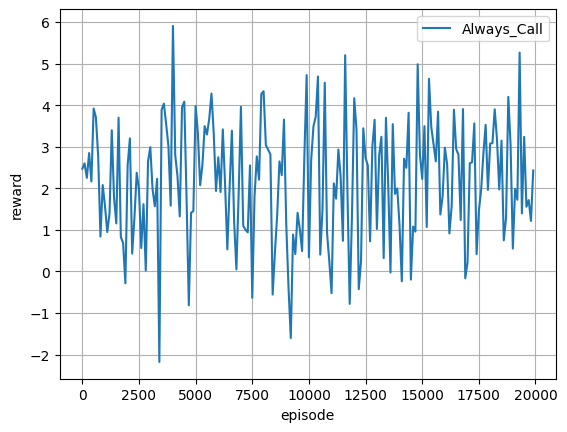

In [86]:
import os
import torch

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'Always_Call'           #change the algorithm by dqn, Always_Call, Special, Always_Raise, nfsp
log_dir = './logs/'
num_episodes = 20000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[64,64],
        q_mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
traj_per_episode = []

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        traj = []
        for ts in trajectories[0]:
            event = {}
            event["me"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            event["opponent"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            traj.append(event)
        traj_per_episode.append(traj)
        for ts in trajectories[0]:
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))


    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



We only ran 20,000 episodes because we know the agent won't improve due to its deterministic play. The goal was primarily to observe the average reward before comparing it to the DQN agent.



### 4.2 Regression Always Call Agent 

We add a regression line to see the general trend

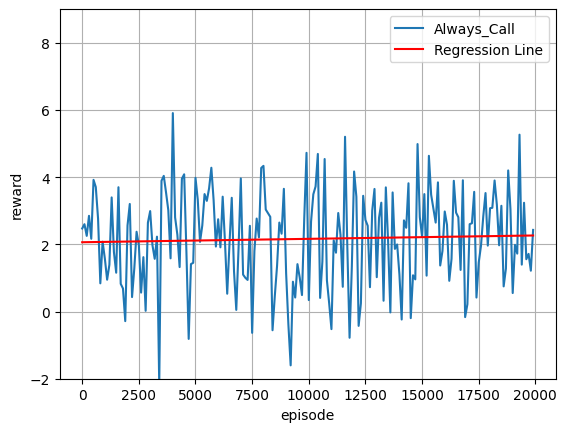

In average a Always Call Agent as a reward of 2.1623900000000003


In [88]:
# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]
# Calculate regression line

coefficients = np.polyfit(x, y, 1)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression line
plt.plot(x, y_reg, color='r', label='Regression Line')
plt.ylim(-2, 9)  # Set y-axis limits
plt.legend()


# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()

print("In average a Always Call Agent as a reward of", sum(y_reg)/len(y_reg))

This agent has a reward of only 2,16 compared to 6 with the DQN agent, demonstrating that the DQN agent performs significantly better than an algorithm with a simple strategy.

### 4.3 Action made by Always Call Agent 


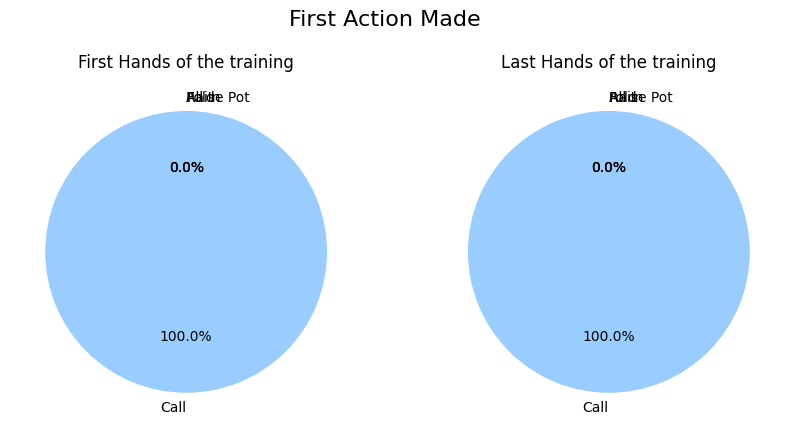

In [91]:

hands_only = [ep[0]["me"]["hand"] for ep in traj_per_episode] # Extract the hands played#
action_made = [ep[0]["me"]["action"] for ep in traj_per_episode]
stage_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode]
stakes_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode]   


number = int((num_episodes)/10)

hands_only_1000 = hands_only[:number] 
action_made_1000 = action_made[:number]
stage_played_1000 = stage_played[:number]
stakes_played_1000 = stakes_played[:number] 

hands_only_1000_end = hands_only[-number:]
action_made_1000_end = action_made[-number:]
stage_played_1000_end = stage_played[-number:]
stakes_played_1000_end = stakes_played[-number:]


# Calculate the ratios of different actions made in the first 1000 hands
total_actions_1000 = len(action_made_1000)
raise_ratio_call_1000 = action_made_1000.count(1) / total_actions_1000
raise_ratio_fold_1000 = action_made_1000.count(0) / total_actions_1000
raise_ratio_half_pot_1000 = action_made_1000.count(2) / total_actions_1000
raise_ratio_pot_1000 = action_made_1000.count(3) / total_actions_1000
raise_ratio_allin_1000 = action_made_1000.count(4) / total_actions_1000

# Calculate the ratios of different actions made in the last 1000 hands
total_actions_1000_end = len(action_made_1000_end)
raise_ratio_call_1000_end = action_made_1000_end.count(1) / total_actions_1000_end
raise_ratio_fold_1000_end = action_made_1000_end.count(0) / total_actions_1000_end
raise_ratio_half_pot_1000_end = action_made_1000_end.count(2) / total_actions_1000_end
raise_ratio_pot_1000_end = action_made_1000_end.count(3) / total_actions_1000_end
raise_ratio_allin_1000_end = action_made_1000_end.count(4) / total_actions_1000_end

# Pie chart data
labels = ['Call', 'Fold', 'Raise Pot', 'All In']
colors = ['#99CCFF', '#CCE5FF', '#66B3FF','#0099FF']

sizes = [raise_ratio_call, raise_ratio_fold, raise_ratio_pot, raise_ratio_allin]
sizes_1000 = [raise_ratio_call_1000, raise_ratio_fold_1000, raise_ratio_pot_1000, raise_ratio_allin_1000]
sizes_1000_end = [raise_ratio_call_1000_end, raise_ratio_fold_1000_end, raise_ratio_pot_1000_end, raise_ratio_allin_1000_end]
# , 'Raise Half Pot' , raise_ratio_half_pot, raise_ratio_half_pot_1000, raise_ratio_half_pot_1000_end

# Plot pie charts
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('First Action Made', fontsize=16)


axs[0].pie(sizes_1000, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title('First Hands of the training')

axs[1].pie(sizes_1000_end, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].set_title('Last Hands of the training')

plt.show()




As expected, the agent that always calls plays as intended.

Technically, these graphs are not useful, but they serve as a way to verify that the Always Call agent is functioning correctly.

We won't show other graphs about how the hands are played because we know that the agent plays every hand the same way deterministically.

## 5. Analysis of a improved Agent

Now, we also want to evaluate the results of a semi-optimal strategy to ascertain whether DQN truly outperforms it or not.
### 5.1 Special Agent vs Random Agent



--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  6.3985
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  8.4885
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  7.304
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  7.753
----------------------------------------

----------------------------------------
  episode      |  400
  reward       |  6.3715
----------------------------------------

----------------------------------------
  episode      |  500
  reward       |  7.726
----------------------------------------

----------------------------------------
  episode      |  600
  reward       |  6.19
----------------------------------------

----------------------------------------
  episode      |  700
  reward  

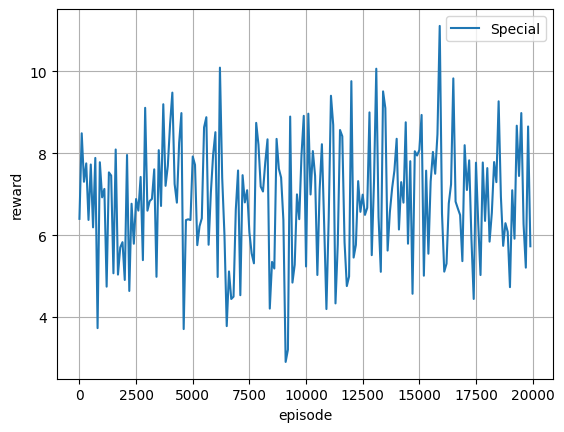

In [92]:
import os
import torch
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'Special'           #change the algorithm by dqn, Always_Call, Special, Always_Raise, nfsp
log_dir = './logs/'
num_episodes = 20000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[64,64],
        q_mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
traj_per_episode = []

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        traj = []
        for ts in trajectories[0]:
            event = {}
            event["me"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            event["opponent"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            traj.append(event)
        traj_per_episode.append(traj)
        for ts in trajectories[0]:
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))
         

    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



### 5.2 Special Agent regression


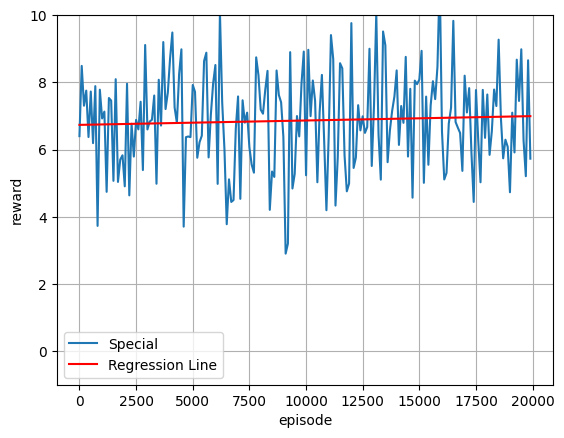

In average a Special Agent as a reward of 6.863274999999999


In [93]:

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]

# Calculate regression line
coefficients = np.polyfit(x, y, 1)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Calculate regression lines for 10% and 90% quantiles
#quantiles_10 = np.percentile(y_reg, 10)
#quantiles_90 = np.percentile(y_reg, 90)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression lines
plt.plot(x, y_reg, color='r', label='Regression Line')
#plt.plot(x, np.full_like(x, quantiles_10), color='g', linestyle='--', label='10% Quantile')
#plt.plot(x, np.full_like(x, quantiles_90), color='g', linestyle='--', label='90% Quantile')

plt.ylim(-1, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()
print("In average a Special Agent as a reward of", sum(y_reg)/len(y_reg))

Surprinsingly the special agent that don't even play perfectly, outperformed the DQN agent. Not by a lot but with a significant margin.

Why can't the DQN agent improve further? We'll delve into this discussion later on.

### 5.3 Special Agent stats




In [96]:

hands_only =[]
#traj_per_episode
for episode in traj_per_episode:
    for hand_info in episode:
        my_hand = hand_info['me']['hand']
        #opponent_hand = hand_info['opponent']['hand']
        hands_only.append(my_hand)
        #hands_only.append(opponent_hand)

action_made = []
for episode in traj_per_episode:
    for hand_info in episode:
        my_action = hand_info['me']['action']
        #opponent_action = hand_info['opponent']['action']
        action_made.append(my_action)
        #action_made.append(opponent_action)

stage_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode]
stakes_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode]   
#hands_only = [action[0] for action in hand_played] # Extract the hands played
#action_made = [action[1] for action in hand_played] # Extract the actions made FOLD, CHECK_CALL, ...
#stage_played = [action[2] for action in hand_played] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
#stakes_played = [action[3] for action in hand_played] # Extract the stakes played

print("During the all the training, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made.count(1) / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count(0) / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made.count(3) / len(action_made)
print("Ratio of raise pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made.count(2) / len(action_made)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count(4) / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")


# Calculate the ratio of each action type
num_actions = len(action_made)
ratios = [action_made.count(i) / num_actions for i in range(5)]

# Define action labels
action_labels = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-In']

# Define colors
colors = ['#99CCFF', '#CCE5FF', '#66B3FF', '#0099FF']

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=action_labels, values=ratios, hole=0.3, marker=dict(colors=colors))])

# Update layout
fig.update_layout(title='Distribution of Actions During all the Training')

# Save the plot
plot_dir = log_dir
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

plot_path = os.path.join(plot_dir, 'action_distribution_pie_chart.html')
fig.write_html(plot_path)
plot(fig, filename=f'{plot_path}', auto_open=True)

print(f'Action distribution pie chart saved in {plot_path}')









During the all the training, the model has a:
Ratio of call hands played: 0.375052815284284
Ratio of fold hands played: 0.04013961605584642
Ratio of raise pot hands played: 0.5161201432901625
Ratio of raise half pot hands played: 0.06868742536970698
Ratio of all in hands played: 0.0


Action distribution pie chart saved in ./logs/action_distribution_pie_chart.html


The primary purpose of this graph is to verify if the special model adheres to its intended behavior throughout the entire training process for all stages (preflop to river). The results appear legitimate; we didn't explicitly program the ability for it to go all-in, yet it's functioning as expected.

In [98]:
# Flatten the list of lists
all_hands = [hand for sublist in hands_only for hand in sublist]

# Count the frequency of each hand
hand_counts = Counter(all_hands)

# Create bar plot data
data = go.Bar(
    x=list(hand_counts.keys()),
    y=list(hand_counts.values()),
    marker=dict(color='rgb(65, 131, 215)')
)

# Layout settings
layout = go.Layout(
    title='Frequency of Each Hand Played during the Flop',
    xaxis=dict(title='Hand'),
    yaxis=dict(title='Frequency'), 
    margin=dict(b=100),
)

# Create figure
fig1 = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_frequency.html')
pio.write_html(fig1, plot_path)
# Display the plot inline in Jupyter notebook
plot(fig1, filename=f'{plot_path}', auto_open=True)
print('Frequency plot saved in', plot_path)


# Function to check if the hand is a pair
def is_pair(hand):
    return len(hand) == 2 and len(hand[0]) > 1 and len(hand[1]) > 1 and hand[0][1] == hand[1][1]

# Function to check if 'A' is in one of the two cards
def has_ace(hand):
    return len(hand) == 2 and ((len(hand[0]) > 1 and 'A' in hand[0][1:]) or (len(hand[1]) > 1 and 'A' in hand[1][1:]))

# Function to check if the hand is a suited connector
def is_suited_connector(hand):
    if len(hand) != 2:
        return False
    suits = {'H', 'D', 'C', 'S'}
    ranks = {'2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A'}
    return hand[0][0] == hand[1][0] and (len(hand[0]) > 1 and hand[0][1:] in ranks) and (len(hand[1]) > 1 and hand[1][1:] in ranks)

# Function to check if the hand has specific combinations
def has_specific_combination(hand):
    ranks = {'KQ', 'KJ', 'KT', 'QJ', 'QT', 'JT'}
    return len(hand) == 2 and hand[0][1:] in ranks and hand[1][1:] in ranks

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for hands in hands_only:
    if is_pair(hands):
        pair_count += 1
    elif has_ace(hands):
        ace_count += 1
    elif is_suited_connector(hands):
        suited_connector_count += 1
    elif has_specific_combination(hands):
        specific_combinations_count += 1
    else:
        others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency.html')
pio.write_html(fig, plot_path)
# Display the plot inline in Jupyter notebook
plot(fig, filename=f'{plot_path}', auto_open=True)
print('Frequency plot hand type saved in', plot_path)

# Open the saved HTML file in Visual Studio Code
#webbrowser.open(plot_path)


Frequency plot saved in ./logs/Special_hand_frequency.html
Frequency plot hand type saved in ./logs/Special_hand_type_frequency.html



## 6. Analysis of NFSP Agent

In theory, NFSP (Neural Fictitious Self-Play) is considered more suitable than DQN for reinforcement learning in poker. After making some adjustments, here are the results.

### 6.1 NFSP Agent vs Random Agent

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  -2.1845
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  0.252
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  0.2715
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  -2.353
----------------------------------------

----------------------------------------
  episode      |  400
  reward       |  2.257
----------------------------------------

----------------------------------------
  episode      |  500
  reward       |  -0.569
----------------------------------------
INFO - Step 1000, rl-loss: 1159.0941162109375
INFO - Copied model parameters to target network.
INFO - Step 1051, rl-loss: 1452.0996093758125
----------------------------------------
  episode      | 

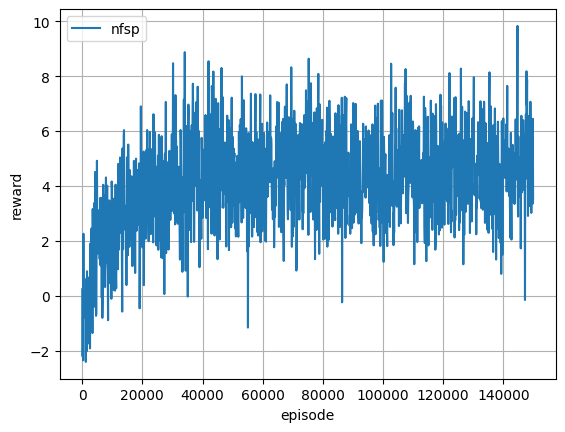

In [99]:
import os
import torch
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'nfsp'           #change the algorithm by dqn, Always_Call, Special, Always_Raise, nfsp
log_dir = './logs/'
num_episodes = 150000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(          #### parameters to be tuned
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[128, 128, 128,128],
        q_mlp_layers=[128, 128, 128,128],
        q_discount_factor=0.98,
        q_update_target_estimator_every = 500,
        rl_learning_rate = 0.01,
        sl_learning_rate = 0.001,

        anticipatory_param=0.1,
        batch_size=512,
        train_every=1,
        min_buffer_size_to_learn=100,
        q_replay_memory_size=50000,
        q_replay_memory_init_size=1000,
        q_epsilon_start=0.1,
        q_epsilon_end=0.01,
        q_epsilon_decay_steps=int(1e5),
        q_batch_size=64,
        q_train_every=1,
        save_every=10000,

        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    #agents.append(SpecialAgent(num_actions=env.num_actions))
    #agents.append(Always_Call_Agent(num_actions=env.num_actions))
    agents.append(RandomAgent(num_actions=env.num_actions))
    #agents.append(RandomAgent(num_actions=env.num_actions))
    #agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
traj_per_episode = []

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        traj = []
        for ts in trajectories[0]:
            event = {}
            event["me"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            event["opponent"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            traj.append(event)
        traj_per_episode.append(traj)
        for ts in trajectories[0]:
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))
        


    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



### 6.2 NFSP Agent regression

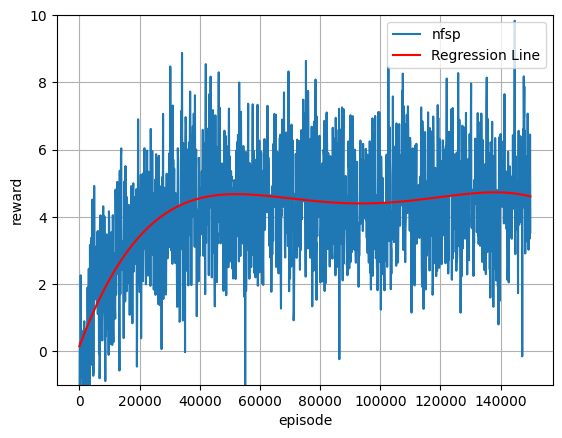

After 40000 episodes, a nfsp Agent as a reward in average of 4.564159625451411


In [103]:

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]

# Calculate regression line
coefficients = np.polyfit(x, y, 4)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Calculate regression lines for 10% and 90% quantiles
#quantiles_10 = np.percentile(y_reg, 10)
#quantiles_90 = np.percentile(y_reg, 90)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression lines
plt.plot(x, y_reg, color='r', label='Regression Line')
#plt.plot(x, np.full_like(x, quantiles_10), color='g', linestyle='--', label='10% Quantile')
#plt.plot(x, np.full_like(x, quantiles_90), color='g', linestyle='--', label='90% Quantile')

plt.ylim(-1, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()
c= len(y_reg)-400
print("After 40000 episodes, a nfsp Agent as a reward in average of", sum(y_reg[-c:])/len(y_reg[-c:]))


For some reason, the reward is lower than that of DQN, but we're interested in examining how different the strategy of this algorithm is.
### 6.2 Statistics about NFSP model 
What did the model do during the training ? Did he learn well or not ?

#### 6.2.1 Ratios of actions  

During the all the training, the model has a:
Ratio of call hands played: 0.28247333333333335
Ratio of fold hands played: 0.0252
Ratio of raise pot hands played: 0.45397333333333334
Ratio of raise half pot hands played: 0.0
Ratio of all in hands played: 0.23835333333333333


During the beggining of the training for the first 1000 hands, the model has a:
Ratio of call hands played: 0.3498
Ratio of fold hands played: 0.0984
Ratio of raise half pot hands played: 0.0
Ratio of raise hands played: 0.2362
Ratio of all in hands played: 0.3156


During the end of the training for the last 1000 hands, the model has a:
Ratio of call hands played: 0.209
Ratio of fold hands played: 0.0097
Ratio of raise half pot hands played: 0.0
Ratio of raise hands played: 0.5679
Ratio of all in hands played: 0.2134




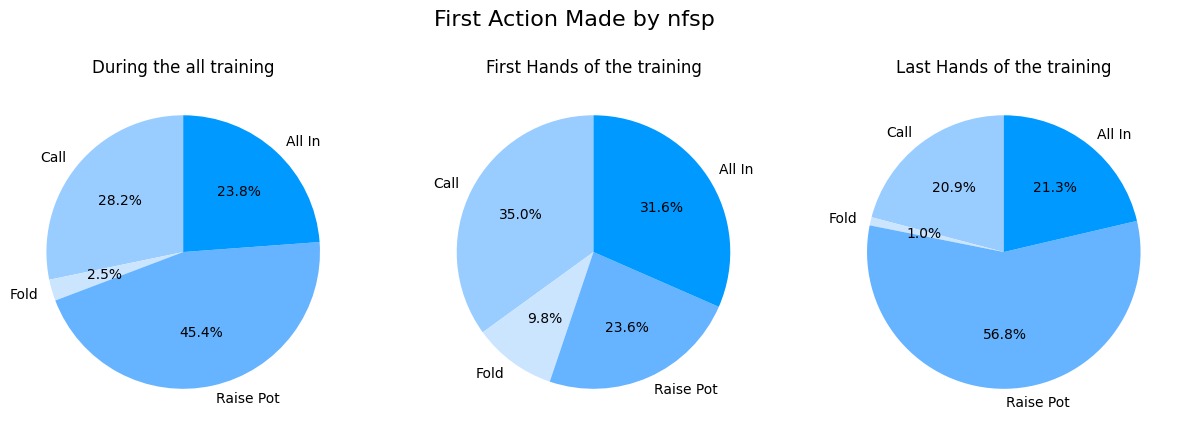

In [104]:
hands_only = [ep[0]["me"]["hand"] for ep in traj_per_episode] # Extract the hands played
action_made = [ep[0]["me"]["action"] for ep in traj_per_episode] # Extract the actions made FOLD, CHECK_CALL, ...
#stage_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
#stakes_played = [ep[0]["me"]["current_stage"] for ep in traj_per_episode]   # Extract the stakes played

print("During the all the training, the model has a:")
# Calculate the ratio of calling hands played
raise_ratio_call = action_made.count(1) / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count(0) / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made.count(3) / len(action_made)
print("Ratio of raise pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made.count(2) / len(action_made)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count(4) / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")
number = int((num_episodes)/15)
hands_only_1000 = hands_only[:number] 
action_made_1000 = action_made[:number]
#stage_played_1000 = stage_played[:number]
#stakes_played_1000 = stakes_played[:number] 

print("During the beggining of the training for the first 1000 hands, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made_1000.count(1) / len(action_made_1000)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made_1000.count(0) / len(action_made_1000)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made_1000.count(2) / len(action_made_1000)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made_1000.count(3) / len(action_made_1000)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made_1000.count(4) / len(action_made_1000)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")


hands_only_1000_end = hands_only[-number:]
action_made_1000_end = action_made[-number:]
##stage_played_1000_end = stage_played[-number:]
#stakes_played_1000_end = stakes_played[-number:]

print("During the end of the training for the last 1000 hands, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made_1000_end.count(1) / len(action_made_1000_end)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made_1000_end.count(0) / len(action_made_1000_end)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised half pot hands played
raise_ratio_raise = action_made_1000_end.count(2) / len(action_made_1000_end)
print("Ratio of raise half pot hands played:", raise_ratio_raise)
# Calculate the ratio of raised pot hands played
raise_ratio_raise = action_made_1000_end.count(3) / len(action_made_1000_end)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made_1000_end.count(4) / len(action_made_1000_end)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")


from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import os
# Calculate the ratios of different actions made overall
total_actions = len(action_made)
raise_ratio_call = action_made.count(1) / total_actions
raise_ratio_fold = action_made.count(0) / total_actions
raise_ratio_half_pot = action_made.count(2) / total_actions
raise_ratio_pot = action_made.count(3) / total_actions
raise_ratio_allin = action_made.count(4) / total_actions

# Calculate the ratios of different actions made in the first 1000 hands
total_actions_1000 = len(action_made_1000)
raise_ratio_call_1000 = action_made_1000.count(1) / total_actions_1000
raise_ratio_fold_1000 = action_made_1000.count(0) / total_actions_1000
raise_ratio_half_pot_1000 = action_made_1000.count(2) / total_actions_1000
raise_ratio_pot_1000 = action_made_1000.count(3) / total_actions_1000
raise_ratio_allin_1000 = action_made_1000.count(4) / total_actions_1000

# Calculate the ratios of different actions made in the last 1000 hands
total_actions_1000_end = len(action_made_1000_end)
raise_ratio_call_1000_end = action_made_1000_end.count(1) / total_actions_1000_end
raise_ratio_fold_1000_end = action_made_1000_end.count(0) / total_actions_1000_end
raise_ratio_half_pot_1000_end = action_made_1000_end.count(2) / total_actions_1000_end
raise_ratio_pot_1000_end = action_made_1000_end.count(3) / total_actions_1000_end
raise_ratio_allin_1000_end = action_made_1000_end.count(4) / total_actions_1000_end

# Pie chart data
labels = ['Call', 'Fold', 'Raise Pot', 'All In']
colors = ['#99CCFF', '#CCE5FF', '#66B3FF','#0099FF']

sizes = [raise_ratio_call, raise_ratio_fold, raise_ratio_pot, raise_ratio_allin]
sizes_1000 = [raise_ratio_call_1000, raise_ratio_fold_1000, raise_ratio_pot_1000, raise_ratio_allin_1000]
sizes_1000_end = [raise_ratio_call_1000_end, raise_ratio_fold_1000_end, raise_ratio_pot_1000_end, raise_ratio_allin_1000_end]
# , 'Raise Half Pot' , raise_ratio_half_pot, raise_ratio_half_pot_1000, raise_ratio_half_pot_1000_end

# Plot pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'First Action Made by {algorithm}', fontsize=16)


axs[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title('During the all training')

axs[1].pie(sizes_1000, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].set_title('First Hands of the training')

axs[2].pie(sizes_1000_end, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[2].set_title('Last Hands of the training')

plt.show()




We immediatly see the difference with DQN if we compare the end of the training, NFSP goes all in twice more than DQN, call 30% compare to 46% for DQN, raise 49% compare to 40% for DQN, and fold 3 times less


#### 6.2.2 Ratios of hands


In [109]:


def normalize_hand(hand):
    return ''.join(sorted(hand))

def plot_single_hand(hand, save_path):
    plt.figure()
    plt.bar(hand['player'], hand['player'].values(), color='blue')
    plt.xlabel('Player')
    plt.ylabel('Number of chips')
    plt.title('Last Hand')
    plt.savefig(save_path)
    plt.close()

# Flatten the list of lists and normalize each hand
all_hands = []
all_hands_with_action = []

for i in range(len(hands_only)):
    hand_value = normalize_hand(hands_only[i][0][1] + hands_only[i][1][1])
    all_hands.append(hand_value)
    all_hands_with_action.append((hand_value, action_made[i]))

# Count the frequency of each hand
hand_counts = Counter(all_hands)

# Sort the hand counts by hand value
sorted_hand_counts = sorted(hand_counts.items(), key=lambda x: x[0])

# Extract sorted keys and values
sorted_hands, sorted_frequencies = zip(*sorted_hand_counts)



# Define a function to create a plot for a given subset of data
def create_frequency_plot(hand_counts_with_action, title_suffix, plot_path):
    # Sort the hand counts by hand value
    sorted_hand_counts_action = sorted(hand_counts_with_action.items(), key=lambda x: x[0])
    # Extract sorted keys and values
    sorted_hand_counts_action, sorted_frequencies = zip(*sorted_hand_counts_action)
    first_elements = [item[0] for item in sorted_hand_counts_action]
    second_elements = [item[1] for item in sorted_hand_counts_action]

    # Define shades of red
    color_palette = [
        'rgb(255, 204, 204)',  # Light red
        'rgb(255, 153, 153)',  # Medium light red
        'rgb(255, 255, 255)',  # White
        'rgb(255, 102, 102)',  # Medium dark red
        'rgb(255, 51, 51)'     # Dark red
    ]
    
    # Define action labels
    action_labels = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-in']

    # Create a list to hold colors for each bar based on adjusted_second_elements
    colors = [color_palette[val] for val in second_elements]
    
    # Create bar plot data
    data = go.Bar(
        x=list(first_elements),
        y=list(sorted_frequencies),
        marker=dict(color=colors)
    )

    # Annotations for legend
    annotations = [
        dict(
            x=1.07,
            y= 0.1 * i,
            xref='paper',
            yref='paper',
            text=f'<span style="color:{color_palette[i]};">{action_labels[i]}</span>',
            showarrow=False,
            align='left'
        ) for i in range(len(action_labels))
    ]

    # Layout settings
    layout = go.Layout(
        title=f'Frequency of Each Hand Played Postflop ({title_suffix})',
        xaxis=dict(title='Hand'),
        yaxis=dict(title='Frequency'), 
        margin=dict(b=100),
        annotations=annotations
    )

    # Create figure
    fig = go.Figure(data=[data], layout=layout)

    # Display the plot inline in Jupyter notebook
    plot(fig, filename=f'{plot_path}', auto_open=True)
    
    # Save the plot as an HTML file
    pio.write_html(fig, plot_path)

    print('Frequency plot saved in', plot_path)

# Count the frequency of each hand
hand_counts_with_action = Counter(all_hands_with_action)
hand_counts_with_action_begin = Counter(all_hands_with_action[:number])
hand_counts_with_action_end = Counter(all_hands_with_action[-number*10:])    # we can change the last hand here we choose the hands after the plateau

# Create plots for different subsets of data
create_frequency_plot(hand_counts_with_action, 'All Data', os.path.join(log_dir, f'{algorithm}_hand_frequency_action_all.html'))
create_frequency_plot(hand_counts_with_action_begin, 'Beginning', os.path.join(log_dir, f'{algorithm}_hand_frequency_action_beginning.html'))
create_frequency_plot(hand_counts_with_action_end, 'End', os.path.join(log_dir, f'{algorithm}_hand_frequency_action_end.html'))


Frequency plot saved in ./logs/nfsp_hand_frequency_action_all.html
Frequency plot saved in ./logs/nfsp_hand_frequency_action_beginning.html
Frequency plot saved in ./logs/nfsp_hand_frequency_action_end.html


#### 6.2.3 Ratios of type of hands


In [110]:

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for hands in hands_only:
    if is_pair(hands):
        pair_count += 1
    elif has_ace(hands):
        ace_count += 1
    elif is_suited_connector(hands):
        suited_connector_count += 1
    elif has_specific_combination(hands):
        specific_combinations_count += 1
    else:
        others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Specify custom colors for each category
colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors),insidetextfont=dict(size=20))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency.html')
pio.write_html(fig, plot_path)
# Display the plot inline in Jupyter notebook
plot(fig, filename=f'{plot_path}', auto_open=True)
print('Frequency plot saved in', plot_path)

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for action, hands in zip(action_made_1000, hands_only_1000):
    if action > 0:
        if is_pair(hands):
            pair_count += 1
        elif has_ace(hands):
            ace_count += 1
        elif is_suited_connector(hands):
            suited_connector_count += 1
        elif has_specific_combination(hands):
            specific_combinations_count += 1
        else:
            others_count += 1


# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Specify custom colors for each category
colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors),insidetextfont=dict(size=20))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop for the first 1000 hands'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency_first_hands.html')
pio.write_html(fig, plot_path)
# Display the plot inline in Jupyter notebook
plot(fig, filename=f'{plot_path}', auto_open=True)
print('Frequency plot first hands saved in', plot_path)

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for action, hands in zip(action_made_1000_end, hands_only_1000_end):
    if action > 0:
        if is_pair(hands):
            pair_count += 1
        elif has_ace(hands):
            ace_count += 1
        elif is_suited_connector(hands):
            suited_connector_count += 1
        elif has_specific_combination(hands):
            specific_combinations_count += 1
        else:
            others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Specify custom colors for each category
colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']

# Create the pie chart
data = go.Pie(labels=labels, values=values, marker=dict(colors=colors),insidetextfont=dict(size=20))

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop for the last 1000 hands'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency_last_hands.html')
pio.write_html(fig, plot_path)
# Display the plot inline in Jupyter notebook
plot(fig, filename=f'{plot_path}', auto_open=True)
print('Frequency plot last hands saved in', plot_path)


Frequency plot saved in ./logs/nfsp_hand_type_frequency.html
Frequency plot first hands saved in ./logs/nfsp_hand_type_frequency_first_hands.html
Frequency plot last hands saved in ./logs/nfsp_hand_type_frequency_last_hands.html


No significative difference between the beginning and the end

#### 6.2.4 Ratios of actions by type of hand

In [113]:


# Initialize counters
action_counts = [0, 0, 0, 0, 0]  # counts for actions 0, 1, 2, 3, 4
hand_counts = [[0, 0, 0, 0, 0] for _ in range(5)]  # counts for each hand type for each action

# Categorize hands
for action, hands in zip(action_made_1000, hands_only_1000):
    if action >= 0 and action <= 4:
        action_counts[action] += 1
        if is_pair(hands):
            hand_counts[action][0] += 1
        elif has_ace(hands):
            hand_counts[action][1] += 1
        elif is_suited_connector(hands):
            hand_counts[action][2] += 1
        elif has_specific_combination(hands):
            hand_counts[action][3] += 1
        else:
            hand_counts[action][4] += 1

# Create pie charts for each action
plots = []
action_titles = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-In']
for i, action_title in enumerate(action_titles):
    labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
    values = hand_counts[i]
    # Specify custom colors for each category
    colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']
    # Create the pie chart
    data = go.Pie(labels=labels, values=values, marker=dict(colors=colors), insidetextfont=dict(size=20))

    layout = go.Layout(
        title=f'Frequency of Each Type of Hand Played when {action_title} for the first hands'
    )
    fig = go.Figure(data=[data], layout=layout)
    plots.append(fig)

# Save the plots
plot_dir = log_dir
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

for i, fig in enumerate(plots):
    if i != 2:    
        plot_path = os.path.join(plot_dir, f'action_{action_titles[i].lower().replace("/", "_")}_hand_type_frequency_first_hands_{algorithm}_2opponents.html')
        fig.write_html(plot_path)
        # Display the plot inline in Jupyter notebook
        plot(fig, filename=f'{plot_path}', auto_open=True)
        print(f'Frequency plot for {action_titles[i]} saved in {plot_path}')



# Initialize counters
action_counts = [0, 0, 0, 0, 0]  # counts for actions 0, 1, 2, 3, 4
hand_counts = [[0, 0, 0, 0, 0] for _ in range(5)]  # counts for each hand type for each action

# Categorize hands
for action, hands in zip(action_made_1000_end, hands_only_1000_end):
    if action >= 0 and action <= 4:
        action_counts[action] += 1
        if is_pair(hands):
            hand_counts[action][0] += 1
        elif has_ace(hands):
            hand_counts[action][1] += 1
        elif is_suited_connector(hands):
            hand_counts[action][2] += 1
        elif has_specific_combination(hands):
            hand_counts[action][3] += 1
        else:
            hand_counts[action][4] += 1

# Create pie charts for each action
plots = []
action_titles = ['Fold', 'Check/Call', 'Raise 1/2 Pot', 'Raise Pot', 'All-In']

for i, action_title in enumerate(action_titles):
    labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
    values = hand_counts[i]
    # Specify custom colors for each category
    colors = ['#0099FF', '#66B3FF', '#99CCFF', '#CCE5FF', '#E6F2FF']
    # Create the pie chart
    data = go.Pie(labels=labels, values=values, marker=dict(colors=colors), insidetextfont=dict(size=20))

    layout = go.Layout(
        title=f'Frequency of Each Type of Hand Played when {action_title} for the last hands'
    )
    fig = go.Figure(data=[data], layout=layout)
    plots.append(fig)

# Save the plots
plot_dir = log_dir
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

for i, fig in enumerate(plots):
    if i != 2:    
        plot_path = os.path.join(plot_dir, f'action_{action_titles[i].lower().replace("/", "_")}_hand_type_frequency_last_hands_{algorithm}_2opponents.html')
        fig.write_html(plot_path)
        # Display the plot inline in Jupyter notebook
        plot(fig, filename=f'{plot_path}', auto_open=True)
        print(f'Frequency plot for {action_titles[i]} saved in {plot_path}')



Frequency plot for Fold saved in ./logs/action_fold_hand_type_frequency_first_hands_nfsp_2opponents.html
Frequency plot for Check/Call saved in ./logs/action_check_call_hand_type_frequency_first_hands_nfsp_2opponents.html
Frequency plot for Raise Pot saved in ./logs/action_raise pot_hand_type_frequency_first_hands_nfsp_2opponents.html
Frequency plot for All-In saved in ./logs/action_all-in_hand_type_frequency_first_hands_nfsp_2opponents.html
Frequency plot for Fold saved in ./logs/action_fold_hand_type_frequency_last_hands_nfsp_2opponents.html
Frequency plot for Check/Call saved in ./logs/action_check_call_hand_type_frequency_last_hands_nfsp_2opponents.html
Frequency plot for Raise Pot saved in ./logs/action_raise pot_hand_type_frequency_last_hands_nfsp_2opponents.html
Frequency plot for All-In saved in ./logs/action_all-in_hand_type_frequency_last_hands_nfsp_2opponents.html


## 7. Others tests against multiple opponents with different strategies

### 7.1 NFSP Agent vs Random Agent and Always Call Agent

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  -1.0365
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  0.8325
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  -0.398
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  0.06
----------------------------------------

----------------------------------------
  episode      |  400
  reward       |  -0.0895
----------------------------------------
INFO - Step 1000, rl-loss: 1786.947998046875
INFO - Copied model parameters to target network.
INFO - Step 1056, rl-loss: 1907.5830078125755
----------------------------------------
  episode      |  500
  reward       |  -1.2835
----------------------------------------
INFO - Step 1276, rl-loss: 904.11376953125255
------------

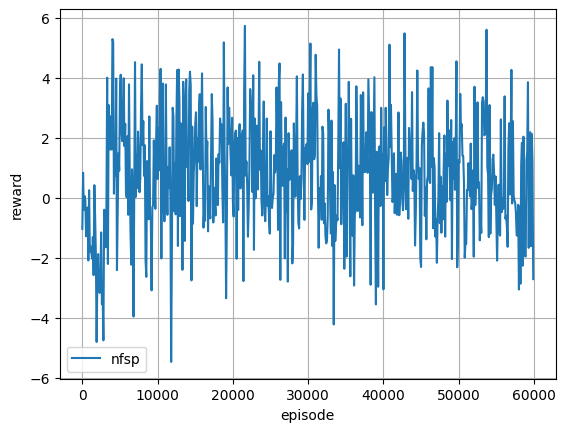

In [114]:
import os
import torch
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'nfsp'           #change the algorithm by dqn, Always_Call, Special, Always_Raise, nfsp
log_dir = './logs/'
num_episodes = 60000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(          #### parameters to be tuned
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[128, 128, 128, 128],
        q_mlp_layers=[128, 128, 128, 128],
        q_discount_factor=0.98,
        q_update_target_estimator_every = 500,
        rl_learning_rate = 0.01,
        sl_learning_rate = 0.001,

        anticipatory_param=0.1,
        batch_size=512,
        train_every=1,
        min_buffer_size_to_learn=100,
        q_replay_memory_size=50000,
        q_replay_memory_init_size=1000,
        q_epsilon_start=0.1,
        q_epsilon_end=0.01,
        q_epsilon_decay_steps=int(1e5),
        q_batch_size=64,
        q_train_every=1,
        save_every=10000,

        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    #agents.append(SpecialAgent(num_actions=env.num_actions))
    agents.append(Always_Call_Agent(num_actions=env.num_actions))
    agents.append(RandomAgent(num_actions=env.num_actions))
    #agents.append(RandomAgent(num_actions=env.num_actions))
    #agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
traj_per_episode = []

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        traj = []
        for ts in trajectories[0]:
            event = {}
            event["me"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            event["opponent"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            traj.append(event)
        traj_per_episode.append(traj)
        for ts in trajectories[0]:
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))


    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve_2opponents.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model_2opponents.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



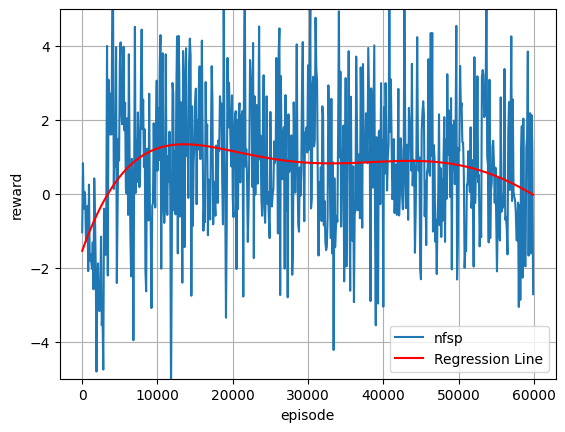

In average a nfsp Agent as a reward of 0.7838221186666384


In [117]:

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]

# Calculate regression line
coefficients = np.polyfit(x, y, 5)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Calculate regression lines for 10% and 90% quantiles
#quantiles_10 = np.percentile(y_reg, 10)
#quantiles_90 = np.percentile(y_reg, 90)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression lines
plt.plot(x, y_reg, color='r', label='Regression Line')
#plt.plot(x, np.full_like(x, quantiles_10), color='g', linestyle='--', label='10% Quantile')
#plt.plot(x, np.full_like(x, quantiles_90), color='g', linestyle='--', label='90% Quantile')

plt.ylim(-5, 5)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot_many_opponents.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()
c= len(y_reg)-200
print("In average a nfsp Agent as a reward of", sum(y_reg[-c:])/len(y_reg[-c:]))


After different tries with different opponents or tweaking of NFSP, we didn't manage to have a good reward...

### 7.3 DQN Agent vs Random Agent and Always Call Agent

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.2075
----------------------------------------
INFO - Step 100, rl-loss: 1757.9608154296875
INFO - Copied model parameters to target network.
INFO - Step 192, rl-loss: 1560.4035644531255
----------------------------------------
  episode      |  100
  reward       |  1.5965
----------------------------------------
INFO - Step 391, rl-loss: 3206.6835937593755
----------------------------------------
  episode      |  200
  reward       |  0.372
----------------------------------------
INFO - Step 578, rl-loss: 1248.1867675781255
----------------------------------------
  episode      |  300
  reward       |  3.337
----------------------------------------
INFO - Step 777, rl-loss: 1947.9304199218755
----------------------------------------
  episode      |  400
  reward       |  1.3675
----------------------------------------
INFO - Step 973, rl-loss: 2787.0798339843755
---------------

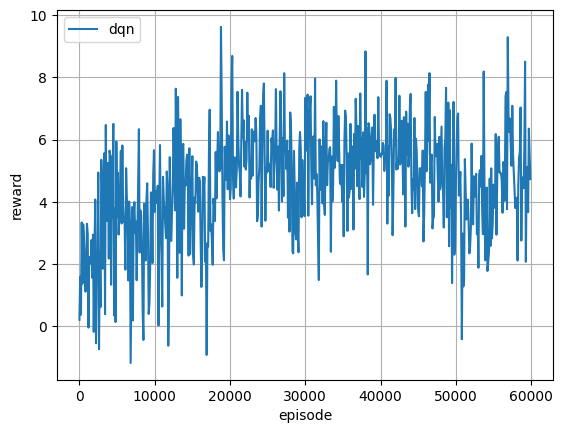

In [118]:
import os
import torch
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'dqn'           #change the algorithm by dqn, Always_Call, Special, Always_Raise, nfsp
log_dir = './logs/'
num_episodes = 60000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(          #### parameters to be tuned
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[128, 128, 128],
        q_mlp_layers=[128, 128, 128],
        q_discount_factor=0.98,
        q_update_target_estimator_every = 500,
        rl_learning_rate = 0.01,
        sl_learning_rate = 0.001,

        anticipatory_param=0.1,
        batch_size=512,
        train_every=1,
        min_buffer_size_to_learn=100,
        q_replay_memory_size=50000,
        q_replay_memory_init_size=1000,
        q_epsilon_start=0.1,
        q_epsilon_end=0.01,
        q_epsilon_decay_steps=int(1e5),
        q_batch_size=64,
        q_train_every=1,
        save_every=10000,

        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    #agents.append(SpecialAgent(num_actions=env.num_actions))
    agents.append(Always_Call_Agent(num_actions=env.num_actions))
    agents.append(RandomAgent(num_actions=env.num_actions))
    #agents.append(RandomAgent(num_actions=env.num_actions))
    #agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
traj_per_episode = []

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        traj = []
        for ts in trajectories[0]:
            event = {}
            event["me"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            event["opponent"] = {"action":ts[1], "hand": ts[0]['raw_obs']['hand'], "current_stage":ts[0]['raw_obs']['stage'].name}
            traj.append(event)
        traj_per_episode.append(traj)
        for ts in trajectories[0]:
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))


    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve_2opponents.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model_2opponents.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



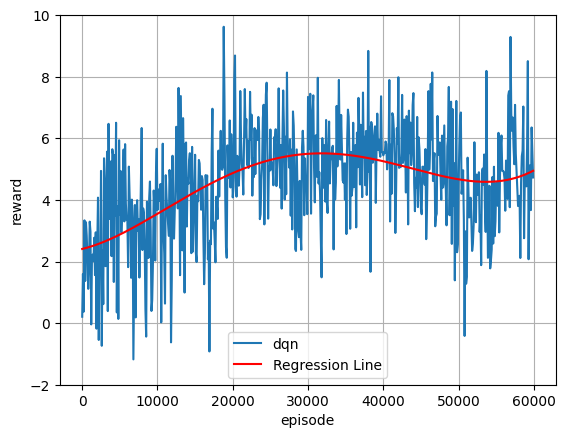

In average a nfsp Agent as a reward of 5.080091209684933


In [119]:

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]

# Calculate regression line
coefficients = np.polyfit(x, y, 4)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Calculate regression lines for 10% and 90% quantiles
#quantiles_10 = np.percentile(y_reg, 10)
#quantiles_90 = np.percentile(y_reg, 90)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression lines
plt.plot(x, y_reg, color='r', label='Regression Line')
#plt.plot(x, np.full_like(x, quantiles_10), color='g', linestyle='--', label='10% Quantile')
#plt.plot(x, np.full_like(x, quantiles_90), color='g', linestyle='--', label='90% Quantile')

plt.ylim(-2, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot_many_opponents.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()
c= len(y_reg)-200
print("In average a nfsp Agent as a reward of", sum(y_reg[-c:])/len(y_reg[-c:]))


## 8. Play against the model

Now that we have everything, we add the option to play against the model,
https://github.com/datamllab/rlcard/blob/master/examples/human/nolimit_holdem_human.py

We have 1 limitation : if we go all-in before the river against the bot, the community cards not dealt aren't displayed but the game knows who's winning or not.

You can change the cell below to play against DQN model, the Special model, NFSP model or DQN 2 ooponents model


In [120]:
agent = torch.load('logs/dqn_model.pth')        #comment this line and uncomment the other to play against special, nfsp or dqn_2opponents
#agent = torch.load('logs/Special_model.pth')
#agent = torch.load('logs/nfsp_model.pth')  
#agent = torch.load('logs/dqn_model_2opponents.pth')  

In [68]:

from rlcard.agents import NolimitholdemHumanAgent as HumanAgent
from rlcard.utils import print_card

# Make environment
env = rlcard.make(
    'no-limit-holdem',
    config={
        'seed': 41, # A fixed seed is used here for illustration purpose
    }
)


human_agent =agent
human_agent2 =  HumanAgent(env.num_actions)
# random_agent = RandomAgent(num_actions=env.num_actions)
env.set_agents([human_agent2, human_agent])


while (True):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action
    final_state = trajectories[0][-1]
    action_record = final_state['action_record']
    state = final_state['raw_obs']
    _action_list = []
    for i in range(1, len(action_record)+1):
        if action_record[-i][0] == state['current_player']:
            break
        _action_list.insert(0, action_record[-i])
    for pair in _action_list:
        print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('===============     Cards all Players    ===============')
    for hands in env.get_perfect_information()['hand_cards']:
        print_card(hands)

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
    elif payoffs[0] == 0:
        print('It is a tie.')
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
    print('')

    input("Press any key to continue...")


>> Start a new game

=============== Community Card ===============









=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│7        │   │2        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♠    │
│         │   │         │
│         │   │         │
│        7│   │        2│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 3
Remaining: [99, 98]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CHECK_CALL, 2: Action.RAISE_POT, 3: Action.ALL_IN

{'hand': ['C7', 'S2'], 'public_cards': [], 'all_chips': [1, 2], 'my_chips': 1, 'legal_actions': [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>], 'stakes': [99, 98], 'current_player': 0, 'pot': 3, 'stage': <Stage.PREFLOP: 0>}
>> Player 1 chooses Action.CHECK_CALL

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐
│9        │   │A        │   │6        │
│         │

ValueError: invalid literal for int() with base 10: ''